# Goal of the project

The goal of this project is to control a 2D quadrotor to get it to perform acrobatic moves. The controllers will be designed using the iterative LQR (iLQR) algorithm.

## 2D quadrotor

The quadrotor is depicted in the following figure <img src='quadrotor.png' width="300">
The quadrotor model is written as
$$\begin{align} 
\dot{x} &= v_x\\
m \dot{v}_x &= - (u_1 + u_2) \sin \theta \\ 
\dot{y} &= v_y\\
m \dot{v}_y &= (u_1 + u_2) \cos \theta  - m g\\
\dot{\theta} &= \omega\\
I \dot{\omega} &= r (u_1 - u_2) \end{align}$$
where $x$ is the horizontal and $y$ the vertical positions of the quadrotor and $\theta$ is its orientation with respect to the horizontal plane. $v_x$ and $v_y$ are the linear velocities and $\omega$ is the angular velocity of the robot. $u_1$ and $u_2$ are the forces produced by the rotors (our control inputs). $m$ is the quadrotor mass, $I$ its moment of inertia (a scalar), $r$ is the distance from the center of the robot frame to the propellers and $g$ is the gravity constant. To denote the entire state, we will write $z = [x, v_x, y, v_y, \theta, \omega]^T$ - we will also write $u = [u_1, u_2]^T$.

The module ```quadrotor.py``` defines the class ```Quadrotor``` that provides all the useful information about the robot and methods to simulate and animate it as shown below.

Please write the answer to all questions that are not asking for code in the report (as a single pdf file). Please submit your code as runnable Jupyter Notebooks (one for each part) or as runnable python scripts.


## Part 1 - Setting up
1. Discretize the system dynamics using the Euler method seen in class - write the time discretization step as $\Delta t$ (use symbols not numbers for the mass, etc)
2. Assume that robot starts at an arbitrary position $x(0) = x_0$, $y(0) = y_0$ and $\theta(0) = 0$ with 0 velocities. Compute $u_1^*$ and $u_2^*$ such that the robot stays at this position forever after (you may test your answer using the simulation below).
3. Analyzing the system dynamics, is it possible to move in the x direction while keeping $\theta = 0$? Explain why.
4. Analyzing the system dynamics, is it possible to have the system at rest with $\theta = \frac{\pi}{2}$ (i.e. have the quadrotor in a vertical position)? Explain why.


## Part 2 - LQR to stay in place
Now that we have $u^*$ capable of keeping the robot at rest, we can design a simple controller that ensures that the robot stays in place even when pushed around by random disturbances (e.g. due to the wind). Our task here will be to design a LQR controller that keeps the robot at a predefined position. Since the dynamics is not linear, we need to compute a linear approximation of it.
1. Linearize the dynamics at an arbitrary operating point $\bar{z}$, $\bar{u}$ and write the linearized system dynamics using the variables $\hat{z}_n = z_n - \bar{z}$ and $\hat{u}_n = u_n - \bar{u}$.
2. Write a function ```get_linearization(robot, z, u)``` that returns the matrices A and B given a robot (object of type ```Quadrotor```), a state z and a control u.
3. Using the linearized dynamics, we can design an infinite horizon LQR controller of the form, $\hat{u} = K \hat{z}$ to stabilize the resting point. What will be the actual controller in the original coordinates $u$ as a function of $z$?
4. Design such an infinite-horizon LQR controller to stabilize the origin $z=0$ and test it using the simulator below (Explain your intended design in the report, including the cost function and found control law). In particular, verify that it can handle perturbations by calling the ```simulate``` function with ```disturbance = True``` (when setting disturbance to True, the simulator will generate a random perturbation every 1 second). Simulate your controller for 10 seconds, plot the state evolution and show the animation (show the plots in your report).


## Part 3 - following a trajectory using linearized dynamics
Now we want to follow a given trajectory leveraging a linearized version of the dynamics to design LQ controllers.
1. Assume that we want to follow a circle of radius 1 centered at (0,0) while keeping an orientation $\theta=0$, how does the linearization of the dynamics change along the desired trajectory? Why?
2. Design a tracking controller (using an LQ design) to follow this desired trajectory (Explain your design in the report). 
3. Test the tracking controller with the simulation (with and without the perturbations) and verify that you can indeed track the (x,y) trajectory very well. Are you able to also track $\theta$? (Explain) Analyze your results (including plots of the states, controls, etc). What benefits and issues do you see with this approach?


## Part 4 - iterative LQR
Now we would like to do more complicated motions with the robot, like a flip. In this case, we do not have a prescribed trajectory but we would like to compute a locally optimal trajectory together with the controller. We will design an iterative LQR algorithm to solve this problem.
1. For the first task, we want the robot to reach a vertical orientation $\theta = \frac{\pi}{2}$ at the location $x=3$ and $y=3$ at time $t=5$ starting from $z_0=0$. During the rest of the motion, the robot should try and stay close to the origin. It should also try to keep its control $u$ close to the control needed to keep the robot at rest. We want to make sure the robot reaches the origin $z=0$ at the end of the movement. Find a time-varying cost function that promotes such a behavior (use only quadratic/linear terms for simplicity). Assume $T=10$ seconds.
2. Write a function ```compute_cost(z,u, horizon_length)``` that returns the cost of a trajectory z with control trajectory u.
3. Compute the quadratic approximation of your cost function along a trajectory $z_n$ with control trajectory $u_n$ (this is not just your cost function!)
4. Write a function ```get_quadratic_approximation_cost(z, u, horizon_length)``` that returns the quadratic approximation (Hessian matrices and Jacobians) of the cost function when approximated along the trajectory z with control trajectory u.
5. Write the iLQR algorithm that solves the problem using the functions written above. At each iteration, for the line search, start with $\alpha = 1.$ and decrease it by half when the cost does not improve (you can stop when $\alpha < 0.01$).
6. Test the algorithm using as initial guess $u$ such that the robot is at rest (cf. Part1.2). Analyze your results (probably you will need to "tune" your cost function), plot the initial and final state and control trajectories, show the animation. (use the simulation without perturbations for simplicity). What benefits and issues do you see with this approach?
7. Use iLQR (and a new cost function) to get the quadrotor to do a full flip, trying to reach the upside-down state $x=1.3$, $y=3$ and $\theta = \pi$ at $t=5$ and upright state $x=3$, $y=3$ and $\theta = \pi$ at $t=10$. Analyze your results. What benefits and issues do you see with this approach? Could you run the resulting controller on a real robot?

In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt

import quadrotor

In [2]:
# we create a robot
robot = quadrotor.Quadrotor()

# we can get its mass, half length (r), gravity constant
print(f'm is {robot.mass}')
print(f'r is {robot.length}')
print(f'I is {robot.inertia}')
print(f'g is {robot.g}')

# we can also get the integration step used in the simulation
print(f'dt is {robot.dt}')

# we can get the size of its state and control vector
print(f'number of states {robot.ns} and number of controls {robot.nu}')
print('the states are indexed as follows: x, vx, y, vy, theta, omega')

m is 0.5
r is 0.15
I is 0.1
g is 9.81
dt is 0.01
number of states 6 and number of controls 2
the states are indexed as follows: x, vx, y, vy, theta, omega


In [3]:
def get_linearization(robot, z, u):
    x = z[0]
    vx = z[1]
    y = z[2]
    vy = z[3]
    theta = z[4]
    omega = z[5]
    
    A = np.array([[1., robot.dt, 0., 0., 0., 0.],
                  [0., 1., 0., 0., -robot.dt * np.cos(theta) * (u[0]+u[1])/robot.mass, 0],
                  [0., 0., 1., robot.dt, 0. ,0.],
                  [0., 0., 0., 1, -robot.dt*np.sin(theta)*(u[0]+u[1]), 0.],
                  [0., 0., 0., 0., 1, robot.dt],
                  [0., 0., 0., 0., 0., 1.]],dtype='float')
    
    B = np.array([[0., 0.],
                  [-robot.dt*np.sin(theta)/robot.mass, -robot.dt*np.sin(theta)/robot.mass],
                  [0., 0.],
                  [robot.dt*np.cos(theta)/robot.mass, robot.dt*np.cos(theta)/robot.mass],
                  [0., 0.],
                  [robot.dt*robot.length/robot.inertia, -robot.dt*robot.length/robot.inertia]], dtype='float')

    return A, B


def solve_LQR(A, B, Q, R, N):
    '''
    A, B, Q and R are the matrices defining the OC problem
    QN is the matrix used for the terminal cost
    N is the horizon length
    '''

    list_of_P = []
    list_of_K = []
    
    list_of_P.append(Q)
    
    for n in range(N,0,-1):
        # temp = np.array(B.transpose() @ list_of_P[-1] @ B + R[:,n])
        inverseTemp = np.linalg.inv(B.transpose() @ list_of_P[0] @ B + R)
        PnPlusOne = list_of_P[0]
        list_of_K.insert(0, -inverseTemp @ B.transpose() @ PnPlusOne @ A ) 
        list_of_P.insert(0, Q + A.transpose() @ PnPlusOne @ A + A.transpose() @ PnPlusOne @ B @ list_of_K[0])
        # list_of_P.append(QN)
    
    return list_of_P, list_of_K

def controller(state,i): 
    u = list_of_K[i] @ (state - z0)
    return u
    
# Q=np.array([[10000,0,0,0,0,0],[0,10,0,0,0,0],[0,0,10,0,0,0],[0,0,0,10,0,0],[0,0,0,0,10,0],[0,0,0,0,0,10]])
Q=100000.0*np.eye(6)
R=0.01*np.eye(2)
# z0 = np.zeros([robot.ns,])
z0 = np.array([0., 0., 0., 0., 0., 0.])
u0 = np.array([robot.mass * robot.g / 2,robot.mass * robot.g / 2])
horizon_length = 1000
A, B = get_linearization(robot, z0, u0)
list_of_P, list_of_K = solve_LQR(A, B, Q, R, horizon_length)
t, state, u = robot.simulate(z0, controller, horizon_length, disturbance = True)
    

In [4]:
# # we can simulate the robot but we need to provide a controller of the following form
# def dummy_controller(state, i):
#     """
#         the prototype of a controller is as follows
#         state is a column vector containing the state of the robot
#         i is the index corresponding to the time step in the horizon (useful to index gains K for e.g.)
        
#         this controller needs to return an array of size (2,)
#     """
#     # here we do nothing and just return some non-zero control
#     u1 = 0.5 * robot.g * robot.mass
# #     print(u1)
#     return u1 * np.ones([2,])




# # we can now simulate for a given number of time steps - here we do 10 seconds
# horizon_length = 1000
# z0 = np.zeros([robot.ns,])
# t, state, u = robot.simulate(z0, dummy_controller, horizon_length, disturbance = False)

<IPython.core.display.Javascript object>


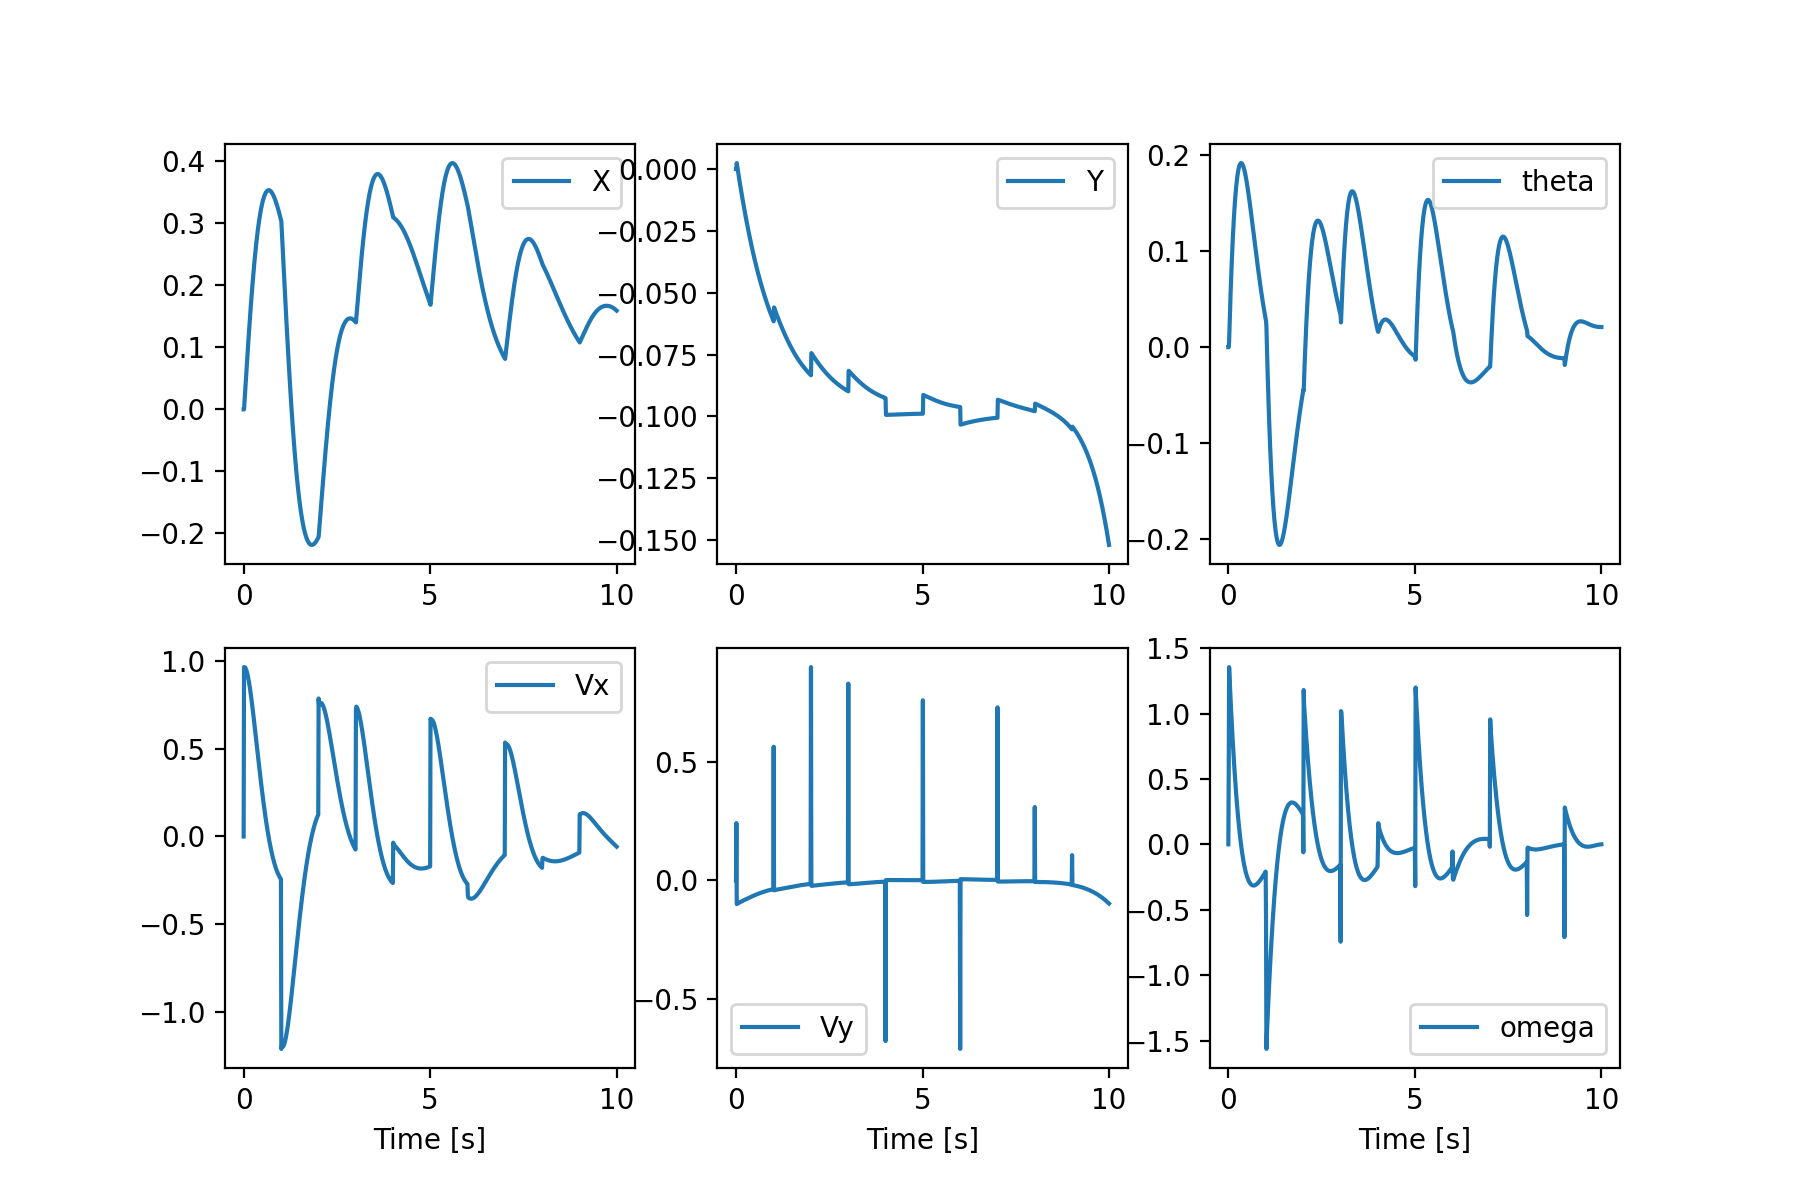

<IPython.core.display.Javascript object>


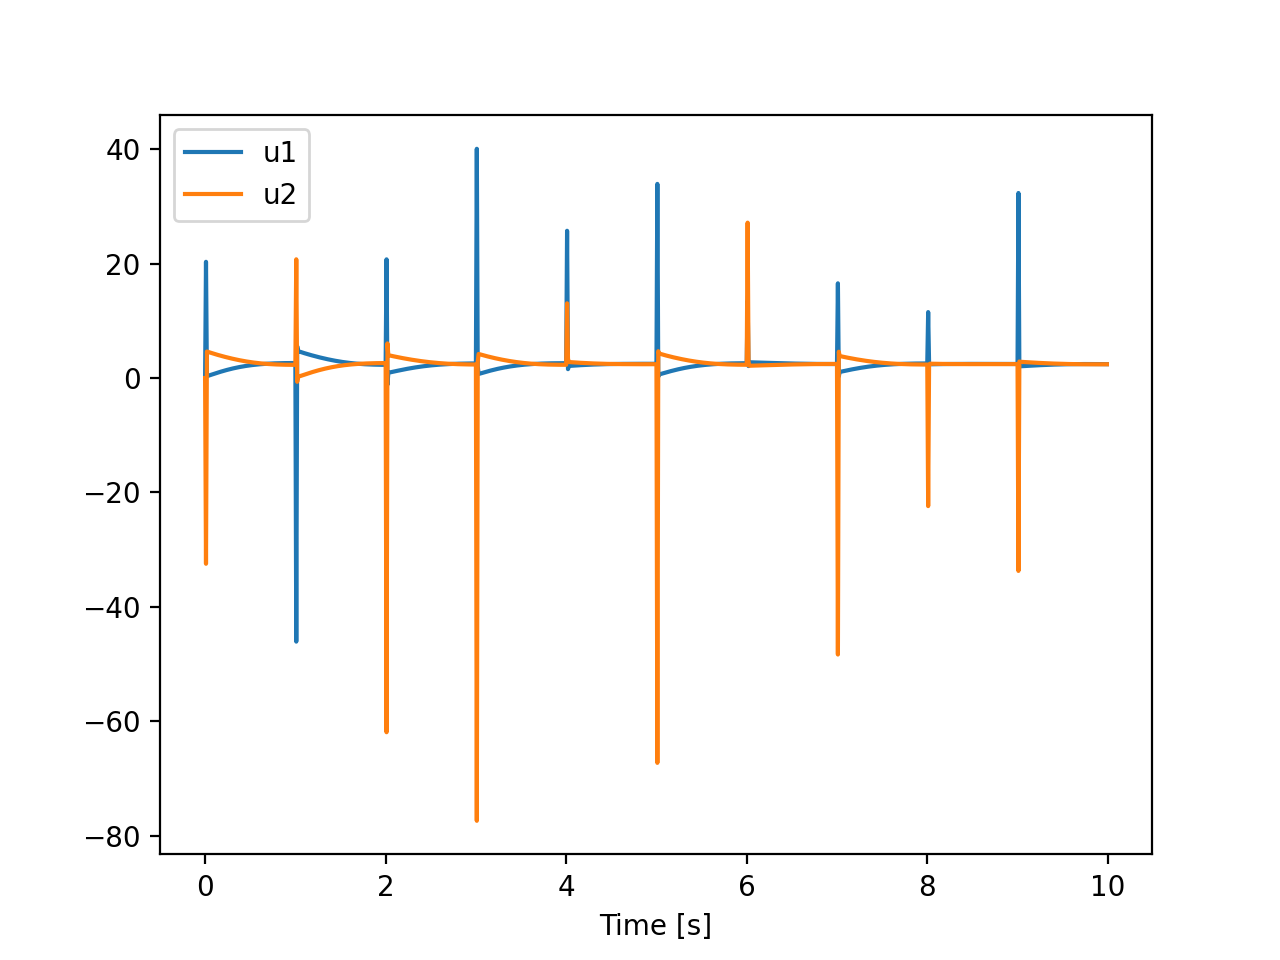

Text(0.5, 0, 'Time [s]')

In [5]:
# we can plot the results
plt.figure(figsize=[9,6])

plt.subplot(2,3,1)
plt.plot(t, state[0,:])
plt.legend(['X'])

plt.subplot(2,3,2)
plt.plot(t, state[2,:])
plt.legend(['Y'])

plt.subplot(2,3,3)
plt.plot(t, state[4,:])
plt.legend(["theta"])

plt.subplot(2,3,4)
plt.plot(t, state[1,:])
plt.legend(['Vx'])
plt.xlabel('Time [s]')

plt.subplot(2,3,5)
plt.plot(t, state[3,:])
plt.legend(['Vy'])
plt.xlabel('Time [s]')

plt.subplot(2,3,6)
plt.plot(t, state[5,:])
plt.legend(['omega'])
plt.xlabel('Time [s]')

# we can also plot the control
plt.figure()
plt.plot(t[:-1], u.T)
plt.legend(['u1', 'u2'])
plt.xlabel('Time [s]')

In [6]:
# now we can also create an animation
robot.animate_robot(state, u)

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAABbQm1kYXQAAAKhBgX//53cRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU3IC0gSC4yNjQvTVBFRy00IEFWQyBjb2RlYyAtIENv
cHlsZWZ0IDIwMDMtMjAxOCAtIGh0dHA6Ly93d3cudmlkZW9sYW4ub3JnL3gyNjQuaHRtbCAtIG9w
dGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFseXNlPTB4MzoweDExMyBtZT1o
ZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVkX3JlZj0xIG1lX3JhbmdlPTE2
IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBkZWFkem9uZT0yMSwxMSBmYXN0
X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTEyIGxvb2thaGVhZF90aHJlYWRz
PTIgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50ZXJsYWNlZD0wIGJsdXJheV9j
b21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBiX3B5cmFtaWQ9MiBiX2FkYXB0
PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29wPTAgd2VpZ2h0cD0yIGtleWlu
dD0yNTAga2V5aW50X21pbj0xMCBzY2VuZWN1dD00MCBpbnRyYV9yZWZyZXNoPTAgcmNfbG9va2Fo
ZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0wLjYwIHFwbWluPTAgcXBtYXg9
NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAAEaZliIQAEP/+94G/MstfIrrJ
cfnnfSyszzzkPHJdia640AAAAwAAAwAAAwAGIxI3/ofxeM38AAADAAC3ABhQDCAKqAwqKe7+J+6n
EAthk3z4NEVsiXDWZ2SIPprNolrAW9coFIQGQQogk1usCkk7gKLcUjLZrhejXtCUcPUjlbYcy+yu
9JWQjvWkunAVPdeDvyF9tLxVjIpotabFMJTVobn7sNL/ZmIE+0nq+5i//d/tW8x5j/WWUm3D1th3
4Lb/lqRonpS6jyVmhmedEfUwaAQY0NNeI9N/r8O7WKv1d/gCdaAl3Gi81o3z2y10tRWcIK0jjKBV
UuThZ+QsHL0juuKYsYerxwqtDlxCDeItdrlLIe68DWXvwKOyDYHEScRYU8BCVbYG+CUL9LfBvAFL
dMKsx8aFL0gHYcZ1oT+thVmulCoT81aUdXAvNWxJVeFoyHDIqUgdhcLMjnuFJjpeTkAmyryQvcvS
4V4TvwAH5GEDH9e+JQ9/0Z+WAeGTsSiZtFgsgBlgUQBbpCIj0eR3Drxa5PEex3LDD+XAg9NDsxW8
cce2l/FR02IVTJaZmpZXtWQ5f3BP8Aty1kv38ceulQsVhdJje6g0l0Bj6XmjYBLS5p2thXBovCDk
56tcwW0pXAmn5ff2hXXmI5Gvc0rDaU9hZI3FzDNi13TNYmkSDf1SKznomzDwO9GxtcvmIrqffe+Q
XHegiGfM63XtT7KB/QMexVdErDPgyaKkGf8V+NqvN+yY8/nsjf2EFx2m8yY4A20h/nzvxj0JGMLe
Hi7wr4sf7PBrPmO4yae5/KjSNEhiaznU538Udp/VNSV+3gxYuD9nZArTtqPvt4yLz39rF9EoPALt
RWEN4d39oavGiY9uez7KFHOitwSyakb+PI3wpb5hosaHKRZsInzk9Cff7PchFzeLIr7egISomBC9
Ve2/Xsxynmmd1ENTAAADAAADAAADAAAE/htllAK04JF28bQCOngzpQuNUKyt4D5BwwOk5Ie/w8Mb
GGo+4umc/7XN4xPgITX/v8P4xXK0cnPq8a36oAR/JNEM4+TBapX4xj+b9wB+V8lwT3O2o56ISGYx
3hiQiFC9I9bUAh+/4OliOWN8L6C7/VdZh6DY4QvaPAlCFTRG93VGQdhJRQP/nWUaBT+q9NwS1xkV
OEO5VE3j/5mYHg3MA7ERhmvAovQIhQIO2WQ0ZYKQmfQn8c6UMjwJs3aF94dpuhgNv05p8iZFN4bC
V4sg4WZXfaTSQ1PNAL7TEkA1RBJAbRyVb3/8isQBpIT5oiDriXZKMf9SOmf57XmzKVEgHydyGAYi
wNOAu2QDbDC2hmMAMef5U2T78u+ycS1SNKFJjMqZD01HIEL8A1gAAAMAAAMAAAMAAAMAyDbHPTOu
5UOUXIW3DenJ6QoPh8mkEFEMxGLjMOWMsBQaLHk0oVP9VylD1GgCJwmzpOb8uwdVLv8ZlDL3raej
2uyfQ+jK0F71qp+gbS+PBobfnjTzDNjlirXRXEqCT02CgX0WWUuZGTlDOLcp5XHgPkxhExtgqbXQ
CC2Sb0I04tgPgral+tXljut0JQ7N1xryPvM5Np7pwLjgXDTkIUB1gg4qaqBXw7jbk4kVucDNwu1u
piuE5VA0YyRpMTS9MLnLHssfAn2U/eHGcaGVfuAydjKq7dSECU+N+9MzT88k4KMdckeSeIr793Da
fGVldB+2Wb52UBz32P9a1zZA1cIpxfFbIZj0aI9jwMRgBf4AQrrUUQtqsfnw3N9TCSNABhWeGDs/
yTENMjKTGiZW+K35Xnf9DtkJw7jKIYISCAx6P5toEIXzOCVtqMJ0kvJ7vnbYKHs39qN08KAPTCLg
CRlFF73h4BNGcTXiFri/rpH6/t0XObVvwewAAAMAAAMAAAnMdbZqrhVcJMEA5flGPNJ0I51kAnte
pzZ+ySnmLrWoP924nVmJBV3+U/6Cv60G9GNdbcuobrFNP3MSmZMaN/4VyV1FrFQVuY6PoNtjJVmY
L2Cs7z2cbuMgvYQuGVo3AjPaefBy47YN+50YaYinjII2YkbMzEaD9qVhXUqe74sCRliYBUKEX4KL
8u1NLT1nSo/BBgHhvofgRtvYJQN2ZOmDJ6JFaxz8+E00ufhtER6lif0W1x1D3Sw3abfrSPgzayLg
SJnno0sV5JERRb6S4wb3d0Ecvl2odRwpW+R1V6I1d+GLtKiUK7wL0+CKCQk5bHLjF9N9b8AewYKr
g1RwEVLiLG8xNpmdnE6tB1VnMObrBbhb9vanGekR0Br2uUtmdoAxtkt+07OfLgJMCGsUm379AzsZ
ihFC7r+fUlGlNf0DjZHKAuxBrmNNmeS+NOkL71c2Hntwd9w91WaflFwiiZDfwkJiwnNOLRqyfwkR
SCv4ji+iQ5xcJnbSBu6Xuw0OAMC8rEG9kCU7/f9F1EN6Br+99/HYgY3B+/+UzwD/9wsergIjg0D0
JQ6gzZSJ3SOIsQtsO6Qxkfq+vQUmqm6PZN1DXtdf/KFqV5iTihuzkC/VnXvAzT13S0uKH0vUZd0p
ueJNQYf1F/bx1u2MrLxRQY63SipoNWOzz8lny5xIZm8VCL1hfJT//M645BVn7JhKxXsD88ORQgAA
AwB3tA6+fbkSGTcAAAMAAAjESP11AdOUdVGEgLMe125AzayvuUeOqKiqAD4Iz3nK3SK9GQ6I6LgB
CTRGi+9evL79qMvUBDm8iHqfuzFtbDY1bV5p1g/X0r7cPuXEpVLUR9CX7M8HZBNbW0FYs70jvqrm
xBoZXPMRNKPumYYsCeTLX2U5keHkTOi++K/3pUewviNO1g2thOI+T8UcZ+2/XRKnKvRfSl0UqOZ8
WxHoFw8duHTrL+uWl3f5ppdmga1tXE6gG9AIQ/AE9pzRgpVcRbnfAUHf2ktEB7sCV+cSNdpkQzZj
V4Oglnbw1vIoLZvNb+50o

In [7]:
# # we can also simulate with perturbations
# t, state, u = robot.simulate(z0, dummy_controller, horizon_length, disturbance = True)

# # we can plot the results
# plt.figure(figsize=[9,6])

# plt.subplot(2,3,1)
# plt.plot(t, state[0,:])
# plt.legend(['X'])

# plt.subplot(2,3,2)
# plt.plot(t, state[2,:])
# plt.legend(['Y'])

# plt.subplot(2,3,3)
# plt.plot(t, state[4,:])
# plt.legend(["theta"])

# plt.subplot(2,3,4)
# plt.plot(t, state[1,:])
# plt.legend(['Vx'])
# plt.xlabel('Time [s]')

# plt.subplot(2,3,5)
# plt.plot(t, state[3,:])
# plt.legend(['Vy'])
# plt.xlabel('Time [s]')

# plt.subplot(2,3,6)
# plt.plot(t, state[5,:])
# plt.legend(['omega'])
# plt.xlabel('Time [s]')

# # we can also plot the control
# plt.figure()
# plt.plot(t[:-1], u.T)
# plt.legend(['u1', 'u2'])
# plt.xlabel('Time [s]')

# robot.animate_robot(state,u)